In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy
import scipy
import pandas
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import subprocess
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
import hpc_lib
#
# TODO: phase out unreferenced hpc_lib calls...
#import hpc_lib
#import hpc_reports
#
def running_mean(X,n=10):
    return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
#

## Realtime Monitoring tools

### General objective:
- Some tools to do realtime monitoring of SERC usage
- Nominally more versatile than that; could be SERC, users, groups, etc. 
- Design some metrics to indicate excessive usage; send alerts; make pretty graphs.

Possible starting query:
        squeue -p serc --Format=jobid,jobarrayid,partition,name,userid,timeused,timeleft,numnodes,nodelist,numcpus,state

Use this to identify:
- An individual user or group using >1/3 of the cluster for >1 hour (or so)
- Generally, times of high impact (lots of running and pending jobs)

Note that it is not trivial to estimate this. Loads of jobs pending is not significant, for example, if they have short runtimes. What we really want to catch is a scenario where a job array (or similar) picks up a bunch of idle resources (eg, overnight when usage is lower) for >24 hour runtime jobs.


In [53]:
# format_fields = {'jobid':str, 'jobarrayid':str, 'partition':str, 'name':str, 'username':str, 'timeused':str, 
#                     'timeleft':str, 'numnodes':int, 'numcpus':int, 'numtasks':int, 'nodelist':str, 'state':str}

class SQUEUE_obj(object):
    # SQUEUE manager, principally to estimate realtime SLURM activity. Like SACCT_obj, but
    #  uses squeue. We *could* use SACCT_obj and just limit to --State=running,pending
    #. but it seems that sacct is much slower than squeue.
    #
    def __init__(self, partition='serc', format_fields_dict=None, squeue_prams=None, verbose=False):
        #
        # @squeue_prams: additional or replacement fields for squeue_fields variable, eg parameters
        #. to pass to squeue. Presently, --Format and --partition are specified. some options might also
        #. be allowed as regular inputs. Probably .update(squeue_prams) will be the last thing done, so 
        #  will overried other inputs.
        #
        # TODO: add ***kwargs and handle syantax like SQU_{something} to add to squeue_fields, etc.
        
        if format_fields_dict is None:
            format_fields_dict = hpc_lib.default_SLURM_types_dict
#             format_fields.update({ky:int for ky in ['NODES', 'CPUS', 'TASKS', 'numnodes', 'numtasks', 'numcpus']})
#             #
#             ff_l = {ky.lower():val for ky,val in format_fields.items()}
#             ff_u = {ky.upper():val for ky,val in format_fields.items()}
#             format_fields.update(ff_l)
#             format_fields.update(ff_u)
#             del ff_l
#             del ff_u

        squeue_fields = {'--Format': ['jobid', 'jobarrayid', 'partition', 'name', 'username', 'timeused', 
                                      'timeleft', 'numnodes', 'numcpus', 'numtasks', 'state', 'nodelist'],
                      '--partition': [partition]
                      }
        if isinstance(squeue_prams, dict):
            squeue_fields.update(squeue_prams)
        #
        squeue_delim='%'
        sinfo_str = 'squeue '
        for ky,vl in squeue_fields.items():
            delim=' '
            if ky.startswith('--'):
                # long format
                delim='='
            #
            sinfo_str = '{} {}{}{}'.format(sinfo_str, ky, delim, f':{squeue_delim},'.join(vl))
        #
        if verbose:
            print('*** sinfo_str: {}'.format(sinfo_str))
            print('*** sinfo_ary: {}'.format(sinfo_str.split()))
        #
        # TODO:
        # port some of these bits to class-scope function calls, for class portability
        #
        self.__dict__.update({ky:vl for ky,vl in locals().items() if not ky in ('self', '__class__')})
        self.set_squeue_data()
    #
    def set_squeue_data(self):
        self.squeue_data = self.get_squeue_data()
        self.dtype       = self.squeue_data.dtype
    #
    def __getitem__(self, *args, **kwargs):
        return self.squeue_data.__getitem__(*args, **kwargs)
    def __setitem__(self, *args, kwargs):
        return self.squeue_data.__setitem__
    #
    def get_squeue_data(self, sinfo_str=None, squeue_delim=None, verbose=False):
        sinfo_str = sinfo_str or self.sinfo_str
        squeue_delim = squeue_delim or self.squeue_delim
        #
        squeue_output = subprocess.run(sinfo_str.split(), stdout=subprocess.PIPE).stdout.decode().split('\n')
        #cols = squeue_output[0].split(squeue_delim)
        #
        # there is a smarter way to do this, eg:
        cols = squeue_output[0].split(squeue_delim)
        for k,cl in enumerate(cols):
            cl_0 = cl
            k_rep = 0
            while cols[k] in cols[0:k]:
                cols[k] = f'{cl}_{k_rep}'
        if verbose:
            print('** cols: ', cols)    
        #
        return pandas.DataFrame(data=[[self.format_fields_dict.get(cl.lower(),str)(x) 
                                  for x, cl in zip(rw.split(squeue_delim),
                                self.squeue_fields['--Format']) ]
                                 for rw in squeue_output[1:]],
                                   columns=cols).to_records()
    #
    def get_active_jobs(self, *args, **kwargs):
        # print('** DEBUG: args: {}'.format(args))
        if len(args)>=6:
            args[5]
        kwargs['do_jobs'] = True
        return get_active_cpus(*args, **kwargs)
    #
    def get_active_cpus(self, state='running,pending', do_refresh=False, state_data=None, ncpus=None, do_cpus=True, do_jobs=False):
        if do_refresh:
            self.set_squeue_data()
        #
        if isinstance(state,bytes):
            state=state.decode()
        if isinstance(state,str):
            state=state.split(',')
        #
        for k,s in enumerate(state):
            state[k] = s.upper()
        #
        if state_data is None:
            state_data = self['STATE']
        if ncpus is None:
            ncpus = self['CPUS']
        #
        ix = numpy.isin(state_data, state)
        n_jobs, n_cpus = numpy.sum(ix), numpy.sum(ncpus[ix])
        #
        if do_cpus and do_jobs:
            return (n_jobs, n_cpus)
        if do_cpus:
            return n_cpus
        if do_jobs:
            return n_jobs
    #
    def simple_wait_estimate(self, ncpus=1, max_cpus=4600, do_refresh=False):
        # TODO: figure out the right way(s) to get max_cpus from system.
        active_cpus = self.get_active_cpus(state='running,pending', do_refresh=do_refresh)
        avail_cpus = max_cpus - active_cpus
        #
        if ncpus <= avail_cpus:
            return 0
        #
        cpus_needed = ncpus - avail_cpus
        #
        # now, spin down self['TIME_LEFT'] until we have enough CPUs to do our job. that TIME_LEFT is
        #. when our job should be available.
        #
        return None
    #
    def report_user_cpu_job_pies(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True, ax1=None, ax2=None):
        #
        # TODO: use scontrol or sinfo to get an automagical cpus_total count.
        #
        user_data = self.get_user_cpu_job_data(state=state, add_idle=add_idle)
        #
        if ax1 is None or ax2 is None:
            fg = plt.figure(figsize=(12,8))
            ax1 = fg.add_subplot(1,2,1)
            ax2 = fg.add_subplot(1,2,2)
        #
        ax1.pie(user_data['jobs'],  labels=user_data['user'], autopct='%.1f')
        ax2.pie(user_data['ncpus'], labels=user_data['user'], autopct='%.1f')
        
        return user_data
    #
    def get_user_cpu_job_data(self, state='RUNNING,PENDING', cpus_total=5456, add_idle=True):
        #partition = partition or self.partition
        if isinstance(state,bytes):
            state=state.decode()
        if isinstance(state,str):
            state = state.split(',')
        sq = self[numpy.isin(self['STATE'].astype(type(state)), state)]
        print('*** ', self['STATE'].astype(type(state))[0:10], '*** ', state)
        #
        users = list([u for u in set(sq['USER']) if not u is None])
        #if add_idle:
        #    users += ['idle']
        print('** users: ', users)
        #
        out_data = numpy.empty(shape=(len(users) + int(add_idle),), 
                    dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
        
        #out_data['jobs'] = numpy.zeros(len(users))
        #out_data['ncpus'] = numpy.zeros(len(users))
        #
        # NOTE: there is also a (faster) syntax to broadcast this, then sum on an axis.
        jobs  = [numpy.sum( (self['USER']==u) ) for u in users]
        ncpus = [numpy.sum( self['CPUS'][(self['USER']==u)] ) for u in users]
        #
        if add_idle:
            jobs += [0]
            ncpus += [cpus_total-numpy.sum(ncpus)]
            users += ['idle']
        #
        out_data['user']  = users
        out_data['jobs']  = jobs
        out_data['ncpus'] = ncpus
        #
        return out_data
        
        
          
        
SQ = SQUEUE_obj()      
#

In [54]:
print('** ', 6*128 + 8*128 + 14*24 + 104*32)
print('*** ', SQ.sinfo_str)
print('** ', SQ.get_active_cpus(state='running,pending'))

**  5456
***  squeue  --Format=jobid:%,jobarrayid:%,partition:%,name:%,username:%,timeused:%,timeleft:%,numnodes:%,numcpus:%,numtasks:%,state:%,nodelist --partition=serc
**  1940.0


***  ['PENDING' 'PENDING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING'
 'RUNNING' 'RUNNING' 'RUNNING'] ***  ['RUNNING', 'PENDING']
** users:  ['jessssli', 'mworden', 'kjavi', 'juwoo', 'klangenf', 'cwilka', 'gegewen', 'jarupas', 'mliu9', 'aguilars', 'earlew', 'divakarv', 'myoder96', 'nurbek', 'cooper96', 'regirock', 'edunham', 'ajaffe', 'hilditch', 'haofu', 'hilley', 'qrlong', 'cbaden']
** 
**  ('jessssli', 1., 55.)
**  ('mworden', 1., 1.)
**  ('kjavi', 1., 8.)
**  ('juwoo', 4., 80.)
**  ('klangenf', 1., 3.)
**  ('cwilka', 1., 8.)
**  ('gegewen', 4., 85.)
**  ('jarupas', 1., 24.)
**  ('mliu9', 1., 3.)
**  ('aguilars', 1., 1.)
**  ('earlew', 2., 252.)
**  ('divakarv', 15., 60.)
**  ('myoder96', 1., 4.)
**  ('nurbek', 1., 2.)
**  ('cooper96', 1., 1.)
**  ('regirock', 1., 1.)
**  ('edunham', 1., 1.)
**  ('ajaffe', 1., 1.)
**  ('hilditch', 1., 16.)
**  ('haofu', 13., 1248.)
**  ('hilley', 3., 3.)
**  ('qrlong', 1., 9.)
**  ('cbaden', 4., 74.)
**  ('idle', 0., 3516.)


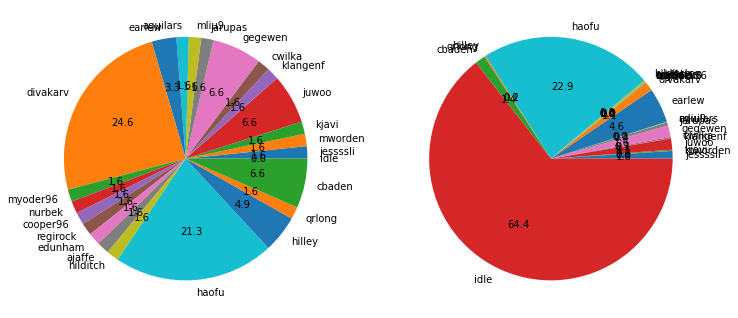

In [55]:
# users = list([u for u in set(SQ['USER']) if not u is None])
# print('** ', users)
#         #
# out_data = numpy.empty(shape=(len(users),), 
#             dtype=[('user', f'U{max([len(s) for s in users])}'), ('jobs', '<f8'), ('ncpus', '<f8')])
# out_data['user'] = users
# out_data['jobs'] = numpy.zeros(len(users))
# out_data['ncpus'] = numpy.zeros(len(users))
# #
# print('** ', out_data)

user_pie = SQ.report_user_cpu_job_pies()
print('** ')
for rw in user_pie:
    print('** ', rw)

In [9]:
print('** sum, ', numpy.sum(user_pie['ncpus']))

** sum,  2279.0


In [6]:
#SQ.set_squeue_data()
print('** users: ', set(SQ['USER']))
#
print('** ', SQ['TIME'][0:20])
print('** ', SQ['TIME_LEFT'][0:20])
print('** ', hpc_lib.elapsed_time_2_day('13:14:10'))

** users:  {'jessssli', 'mworden', 'kjavi', 'juwoo', 'riesr', 'klangenf', 'cwilka', 'gegewen', 'jarupas', 'suihong', 'mliu9', 'aguilars', None, 'earlew', 'qingji', 'divakarv', 'myoder96', 'nurbek', 'cooper96', 'regirock', 'ajaffe', 'haofu', 'hilley', 'qrlong', 'pjwomble', 'cbaden'}
**  [0.00000000e+00 0.00000000e+00 7.78819444e-02 5.95559028e+00
 1.55092593e-03 1.28472222e-03 1.73611111e-03 1.55092593e-03
 9.69907407e-03 2.31538194e+00 4.12965278e+00 3.26835648e+00
 5.28766204e+00 1.08400463e+00 1.04910880e+00 1.04744213e+00
 1.04820602e+00 2.75000000e-02 3.21180556e-02 2.99305556e-02]
**  [3.47222222e-03 1.00000000e+00 1.92211806e+00 1.04440972e+00
 8.17824074e-02 8.20486111e-02 8.15972222e-02 1.23449074e-01
 2.40300926e-01 2.68461806e+00 2.87034722e+00 3.73164352e+00
 1.71233796e+00 3.08266204e+00 3.11755787e+00 3.11922454e+00
 3.11846065e+00 4.13916667e+00 4.13454861e+00 4.13673611e+00]
**  0.5515046296296297


In [31]:
print('** ', SQ.format_fields_dict['time_left'])
print('** ', SQ.dtype)
SQ.get_active_cpus(do_jobs=True, do_cpus=True)

**  <function elapsed_time_2_day at 0x7ff33c37eca0>
**  (numpy.record, [('index', '<i8'), ('JOBID', 'O'), ('JOBID_0', 'O'), ('PARTITION', 'O'), ('NAME', 'O'), ('USER', 'O'), ('TIME', 'O'), ('TIME_LEFT', 'O'), ('NODES', '<f8'), ('CPUS', '<f8'), ('TASKS', '<f8'), ('STATE', 'O'), ('NODELIST            ', 'O')])


(65, 789.0)

In [10]:
print('** ', SQ['STATE'][0:20])
ix = [s in ['RUNNING'] for s in SQ['STATE'] ]

#print('** ', ix)


**  ['PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'RUNNING' 'RUNNING'
 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING'
 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING' 'RUNNING']


In [45]:


# squeue_output = subprocess.run(sinfo_str.split(), stdout=subprocess.PIPE).stdout.decode().split('\n')
# cols = squeue_output[0].split(squeue_delim)

#
#cols = squeue_output.readline()
# cols = squeue_output[0]
# data_dct = {cl:[] for cl in cols}
#
# for now, let's just make a dict with the columns... or use a f***ing PANDAs DF? most of the columns
#. are text-like values, so a recarray or structured numpy array is probably not a good idea... though
#  it's not that difficult to format columns...
#data = []
#for rw in squeue_output:
#    data += [rw.split()]
#
#data_df = pandas.dataframe(data=data[1:], )
#cols = squeue_output.readline()
#data = squeue_output[1:]


In [46]:
print('*** ', squeue_output[0].split(squeue_delim), ' ** ', len(squeue_output[0].split(squeue_delim)))
print('*** ', squeue_output[1].split(squeue_delim), ' ** ', len(squeue_output[1].split(squeue_delim)))

***  ['JOBID', 'JOBID', 'PARTITION', 'NAME', 'USER', 'TIME', 'TIME_LEFT', 'NODES', 'CPUS', 'TASKS', 'STATE', 'NODELIST            ']  **  12
***  ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', '1', '1', '1', 'PENDING', '                    ']  **  12


In [47]:
# print(f'** cols: {squeue_fields["--Format"]}')
# print('** ', squeue_output[0])
# for rw in squeue_output[1:15]:
#     rws = rw.split(squeue_delim)
#     #
#     for x, cl in zip(rws, squeue_fields['--Format']):
#         print('** **', rws)
#         print('* * *', [format_fields_dict.get(cl.lower(),str)(x) for x,cl in zip(rws,squeue_fields['--Format'])] )
    

** cols: ['jobid', 'jobarrayid', 'partition', 'name', 'username', 'timeused', 'timeleft', 'numnodes', 'numcpus', 'numtasks', 'state', 'nodelist']
**  JOBID%JOBID%PARTITION%NAME%USER%TIME%TIME_LEFT%NODES%CPUS%TASKS%STATE%NODELIST            
** ** ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', '1', '1', '1', 'PENDING', '                    ']
* * * ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', 1, 1, 1, 'PENDING', '                    ']
** ** ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', '1', '1', '1', 'PENDING', '                    ']
* * * ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', 1, 1, 1, 'PENDING', '                    ']
** ** ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', '1', '1', '1', 'PENDING', '                    ']
* * * ['60107994', '60107994', 'serc', 'check_scratch_cron', 'cooper96', '0:

In [52]:
sq_data = pandas.DataFrame(data=[[format_fields_dict.get(cl.lower(),str)(x) 
                                  for x, cl in zip(rw.split(squeue_delim),
                                squeue_fields['--Format']) ]
                                 for rw in squeue_output[1:]], columns=squeue_output[0].lower().split(squeue_delim))

In [57]:
print('** ', sq_data.dtypes)
#
ary_sq_data = sq_data.to_records()
print('** ', ary_sq_data.dtype)

**  jobid                    object
jobid                    object
partition                object
name                     object
user                     object
time                     object
time_left                object
nodes                   float64
cpus                    float64
tasks                   float64
state                    object
nodelist                 object
dtype: object


ValueError: name already used as a name or title

In [24]:
for rw in squeue_output[0:10]:
    print('** ', rw.split())

**  ['JOBID', 'JOBID', 'PARTITION', 'NAME', 'USER', 'TIME', 'TIME_LEFT', 'NODES', 'CPUS', 'TASKS', 'NODELIST', 'STATE']
**  ['60052471', '60052471', 'serc', 'pfor_matlab', 'lpulvi', '0:00', '5-00:00:00', '1', '120', '1', 'PENDING']
**  ['60043735', '60043735', 'serc', 'check_scratch_cron', 'cooper96', '0:00', '5:00', '1', '1', '1', 'PENDING']
**  ['60030631', '60030631', 'serc', 'run_realistic_perturaguilars', '0:00', '6-21:00:00', '1', '64', '64', 'PENDING']
**  ['60071705', '60071705', 'serc', 'RCE_299_5_2CO2', 'regirock', '4:03:39', '3-19:56:21', '10', '240', '240', 'sh03-04n[70,72],sh03RUNNING']
**  ['59982531', '59982531', 'serc', 'spg_sa_sal_ncpus250_earlew', '1-07:08:12', '1-02:51:48', '38', '250', '250', 'sh03-04n[45-46,49-51RUNNING']
**  ['60084542', '60084542', 'serc', 'all_iqt', 'mcshea', '30:03', '23:29:57', '1', '8', '8', 'sh03-04n42', 'RUNNING']
**  ['59736211', '59736211_23', 'serc', 'rot_RCE', 'haofu', '5-19:55:34', '1-03:04:26', '9', '144', '144', 'sh03-04n[50-52],sh03